* This notebook is modified from the prerequisite assessment for the deep-learning bootcamp from the Erdos Institute
* Acknowledgement: I would like to thank the Erdos Institute for setting up the assessment and providing the data set

The work below is completed by Ken K. W. Ma on 04 Feb 2024

In [1]:
# import necessary packages

%matplotlib inline

import os # miscelleaneous operating system interface
import numpy as np  # import numpy
import pandas as pd # import pandas
import matplotlib.pyplot as plt 
import seaborn as sns # import seaborn for data visualization

from sklearn.model_selection import train_test_split # splitting data into training and testing set

In [2]:
# import the data set galton.csv as a pandas DataFrame

df=pd.read_csv('galton.csv') # load the data set

df.info() # have a sense of how many columns and the data type for each column
print("\n")
df.head(10) # print the first ten instances to have a look

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   family  898 non-null    object 
 1   father  898 non-null    float64
 2   mother  898 non-null    float64
 3   sex     898 non-null    object 
 4   height  898 non-null    float64
 5   nkids   898 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 42.2+ KB




,family,father,mother,sex,height,nkids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4
5,2,75.5,66.5,M,72.5,4
6,2,75.5,66.5,F,65.5,4
7,2,75.5,66.5,F,65.5,4
8,3,75.0,64.0,M,71.0,2
9,3,75.0,64.0,F,68.0,2


Exploratory data analysis and possible preprocessing before modeling

(i) We see that the data consists of the heights for boys (M) and girls (F). This feature is categorical, so we apply the one-hot encoding to this feature. This can be done by the get dummies command (something like that) in pandas.

(ii) There are five features (family, father, mother, sex of the kids, and number of kids in the family). However, some of these features may be excluded in the fitting as they may not play an important role in the distribution of the kids. We will explore this by using pairplot in seaborn. 

(iii) Before fitting the data, we split the data set to a training set and a test set. Since we only have 898 instances here (relatively small data set), we use the 80%-20% split. Specifically, 80% data is used for the training, and the remaining 20% is used for testing the fit model. The loss function to be used for measuring how good the fit is will depend on the actual model that we are going to use.

(iv) From common sense, we know that sex plays an important role in the height of a person. We want to see its effect here. If the slope of the height vs any one of the feature (say the height of the father), then we may need to introduce interaction terms.

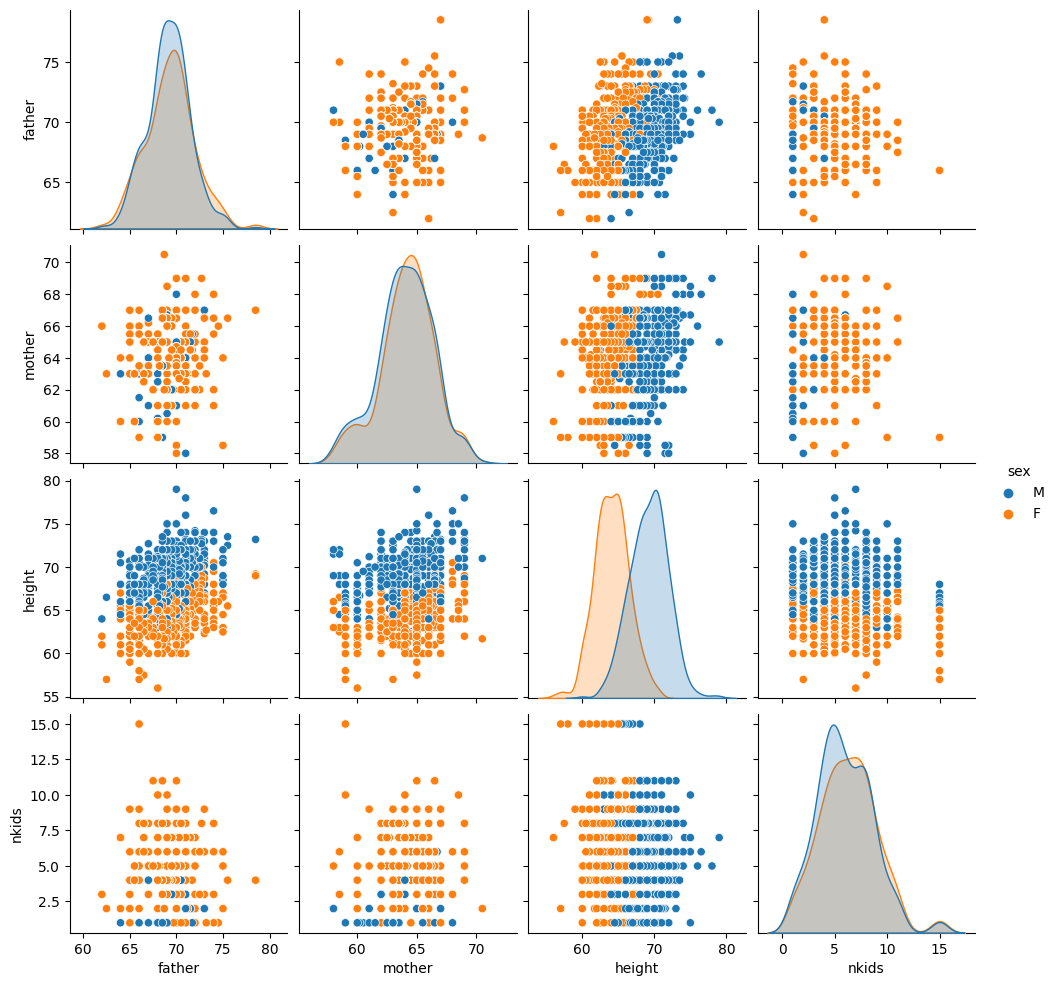

In [3]:
# Have a sense of what features to be included and how they should be included

sns.pairplot(df[['father', 'mother','height','nkids','sex']], hue='sex')
plt.show()

From the EDA above:

It is clear that sex plays an important role in shifting the distribution of the kids' heights. Also, figures (3.1) and (3.2) show that the slopes for the kids' heights with different sexes against their parents' heights are nearly the same. Hence, the feature 'sex' may only lead to a constant shift in the distribution of the height.

Furthermore, family should not a good feature to be included in the fitting model. Otherwise, the model cannot naturally generalize to kids from different families. Hence, we are left with the features: father, mother, sex, height, and nkids. Another observation is that 'nkids' may not play an important role in the distribution of the height, as reflected in the figure (4,3). Hence, we decided to exclude this feature in the fitting. To conclude, we have:

Features in the fitting: father, mother, sex.
Target for the fitting: height.

In [4]:
# One-hot encoding for the sex column

df_dummies=pd.get_dummies(df['sex'])
df['M']=df_dummies['M']
print(df)

# From the output, we see that an additional column is appended
# I do not add the 'F' column as this is redundant

    family  father  mother sex  height  nkids  M
0        1    78.5    67.0   M    73.2      4  1
1        1    78.5    67.0   F    69.2      4  0
2        1    78.5    67.0   F    69.0      4  0
3        1    78.5    67.0   F    69.0      4  0
4        2    75.5    66.5   M    73.5      4  1
..     ...     ...     ...  ..     ...    ... ..
893   136A    68.5    65.0   M    68.5      8  1
894   136A    68.5    65.0   M    67.7      8  1
895   136A    68.5    65.0   F    64.0      8  0
896   136A    68.5    65.0   F    63.5      8  0
897   136A    68.5    65.0   F    63.0      8  0

[898 rows x 7 columns]


We will fit a linear model to the data set and consider the following issues:

1. Interaction terms: 

In principle, we can add interaction terms like 'sex * father', 'sex * mother', etc. However, our EDA above suggests that sex only shifts the height distribution in a constant manner. Hence, I will not include interaction terms here first. If the fitting gives a bad result, we can come back to this issue later.

2. Regularization: 

We have 3 features only in the model, and about 900*0.8=720 instances in the training set. We also use the simple linear regression. Hence, overfitting should not be a problem. We do not inculde regularization first. If overfitting occurs (can be checked by comparing the MSE between the training and test sets), we can add a regularization. We will also check the coefficients (or slopes) for the features 'father' and 'mother'. If the coefficients are unreasonably large, we will also come back and introduce suitable regularization to control the magnitudes of these coefficients. 

3. Assumptions of linear regression:

Linearity - seems to hold from looking at the above pairplots (see figs 3.1 and 3.2)
Normality and Homoscedasticity - can only be checked from the residual plot later after the fitting model is obtained

4. Assessing model fit: 

We will use the root mean square error as the loss function. We evaluate this quantity for the training set and the test set separately. If these two values are close to each other, then we probably have not overfit the data. If both values are small, we believe that the linear fit model does a satisfcatory job.

To summarize, I will first use the following simple linear model with three features to predict the height of the kid:

$$y=a_1*father + a_2*mother + a_3*M+y_0$$

Note that M=1 if the kid is a boy, otherwsie M=0. Here, y_0 is the intercept, which Scikit-Learn will know how to find. It is separated from the coefficients of other features. If the model turns out to be poor or overfitting, we can come back and check if new features (such as interaction terms) or a better regularization is needed.

In [5]:
# Data preprocessing

# Introduce a new column: 'M'. '1' means boy, '0' means girl
# Remove the columns 'family', 'nkids', and 'sex'

df_masked=df.drop(['family','nkids','sex'], axis=1)
df_masked

,father,mother,height,M
0,78.5,67.0,73.2,1
1,78.5,67.0,69.2,0
2,78.5,67.0,69.0,0
3,78.5,67.0,69.0,0
4,75.5,66.5,73.5,1
...,...,...,...,...
893,68.5,65.0,68.5,1
894,68.5,65.0,67.7,1
895,68.5,65.0,64.0,0
896,68.5,65.0,63.5,0


In [6]:
# Use scikit-learn to do the linear regression and evaluate the mean square error (MSE)
# Include stratification to take care of the categorical feature 'sex'

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

df_train, df_test = train_test_split(df_masked, shuffle=True, random_state=42,
                                     stratify=df['sex'], test_size=.2)

# print some basic information for checking before fitting
print ("shape of training set: ", df_train.shape)
print ("shape of test set: ", df_test.shape)
print ("ratio of 'M' in training set: ", np.sum(df_train['M'])/718)
print ("ratio of 'M' in test set: ", np.sum(df_test['M'])/180)
print ("ratio of 'M' in the original data set: ", np.sum(df['M'])/898)

# the ratios look consistent

shape of training set:  (718, 4)
shape of test set:  (180, 4)
ratio of 'M' in training set:  0.5181058495821727
ratio of 'M' in test set:  0.5166666666666667
ratio of 'M' in the original data set:  0.5178173719376392


implement your linear model here.

In [7]:
# implement the linear regression model

lin_reg=LinearRegression()
lin_reg.fit(df_train[['father','mother','M']].values, df_train[['height']].values)

# print out the results 
y_0, y_coeff = lin_reg.intercept_, lin_reg.coef_

print("y intercept: ", np.round(y_0[0], 2))
print("coefficients for father, mother, and sex 'M': ", np.round(y_coeff[0], 2))

# The result is 16.37 + 0.38(father) +0.33(mother) +5.27 (M)

y intercept:  16.37
coefficients for father, mother, and sex 'M':  [0.38 0.33 5.27]


In [8]:
# Check the RMSE, check for any overfitting

ytrain_p = lin_reg.predict(df_train[['father','mother','M']].values)
train_lin_mse = MSE(df_train[['height']], ytrain_p)

ytest_p = lin_reg.predict(df_test[['father','mother','M']].values)
test_lin_mse = MSE(df_test[['height']], ytest_p)

# To have the same dimension 'inch' in height, I take square root for the MSE obtained from Scikit-Learn
print ("RMSE for the linear fit for the training set: ", np.round(np.sqrt(train_lin_mse),2))
print ("RMSE for the linear fit for the test set: ", np.round(np.sqrt(test_lin_mse),2))

# Comments: RMSE for the test set close to the one for the training set -> No overfitting
# Coefficients 0.38, 0.33 not crazily large, look reasonable -> I think I can skip regularization

RMSE for the linear fit for the training set:  2.19
RMSE for the linear fit for the test set:  1.97


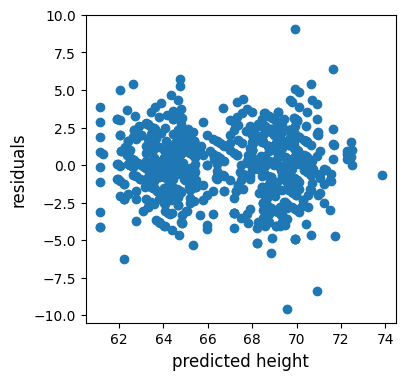

In [9]:
# Checking assumptions of linear regression satisfied: Residual plot
# If the linear model is a good approximation, the residual plot should behave as a gaussian noise

residuals = df_train[['height']] - ytrain_p

plt.figure(figsize=(4,4))

plt.scatter(ytrain_p, residuals)
plt.xlabel("predicted height", fontsize=12)
plt.ylabel("residuals", fontsize=12)

plt.show()

Reconsider the following possible issues:

1. Interaction terms: 

Our EDA above suggests that sex only shifts the height distribution in a constant manner. Hence, interaction terms such as 
father$*M$ and mother$*M$ seem to be unnecessary.

2. Regularization: 

The RMSE for both training and test sets are close to each other, which suggests that there is no overfitting here. In principle, we should also introduce a validation set for hyperparameter tuning. Since I will not do any hyperparameter tuning here, I do not split the training set to a smaller training set and validation set. Furthermore, the magnitudes for the coefficients to the 'father' and 'mother' features are reasonable. Hence, regularization seems to be unnecessary.

3. Assumptions of linear regression: 

The residual plot looks fine, and does not have any obvious heteroscedasticity (except several points with |residuals|>5). Hence, the linear regression model is a suitable model.

4. Assessing model fit: 

The RMSE for the training set is about 2.19 inches. The RMSE for the test set is about 1.97 inches. Since both values are reasonably small, the linear fit model looks good (at least to me).

In [10]:
# We are asked to predict the height of a child whose father is 50 inches and whose mother is 70 inches tall.

# Since the sex of the child is unknown, I will consider the following three predictions:

# (1) Assume the kid is a boy, and use the trained model above
print("If the kid is a boy, predicted height:" ,np.round(lin_reg.predict([[50,70,1]])[0,0],2))

# (2) Assume the kid is a girl, and use the trained model above
print("If the kid is a girl, predicted height:" ,np.round(lin_reg.predict([[50,70,0]])[0,0],2))

If the kid is a boy, predicted height: 63.94
If the kid is a girl, predicted height: 58.67


In [11]:
# (3) Drop the sex feature in the data set and retrain another model with only 'father' and 'mother' as the two features

# create another data frame by dropping the columns 'sex' and 'M'
df_masked2=df.drop(['family','nkids','sex','M'], axis=1)
df_masked2

# train a linear model for this new data frame
df_train2, df_test2 = train_test_split(df_masked2, shuffle=True, random_state=42, test_size=.2)

lin_reg2=LinearRegression()
lin_reg2.fit(df_train2[['father','mother']].values, df_train2[['height']].values)

# print out the results 
np.round(lin_reg2.intercept_,2), np.round(lin_reg2.coef_,2)

#We get 21.7+0.4*(father)+0.28*(mother)

# Study the RMSE for this new model
ytrain2_p = lin_reg2.predict(df_train2[['father','mother']].values)
train2_lin_mse = MSE(df_train2[['height']], ytrain2_p)

ytest2_p = lin_reg2.predict(df_test2[['father','mother']].values)
test2_lin_mse = MSE(df_test2[['height']], ytest2_p)

# To have the same dimension 'inch' in height, I take square root for the MSE obtained from Scikit-Learn
print ("RMSE for the linear fit for the training set: ", np.round(np.sqrt(train2_lin_mse),2))
print ("RMSE for the linear fit for the test set: ", np.round(np.sqrt(test2_lin_mse),2))

print("Predicted height for the kid using the new model:" , np.round(lin_reg2.predict([[50,70]])[0,0],2))

RMSE for the linear fit for the training set:  3.4
RMSE for the linear fit for the test set:  3.31
Predicted height for the kid using the new model: 60.87


We are asked "How much do you trust this prediction and why?"

Using the first model, the predicted height for the kid is 

63.9 inches (if the kid is a boy)
58.7 inches (if the kid is a girl)

Using the second model with the sex feature ignored, the predicted height for the kid is 60.9 inches

How much should I trust this prediction?

For the first model, I will trust the prediction more as sex is included in the linear regression model. RMSE for both training and test sets are about 2 inches. Therefore, the predicted height and the actual height may be off by about 2 inches on average. For the second model (in which sex is not a feature), I view the predicted height as a rough estimation only. Since the sex of the child can lead to a shift of about 5 inches there (from the 1st model), it is important to know this information before giving any prediction. 

Part 1 - Lienar regression completed

* Intentionally leave blank here

Part 2 - Predicting sex from height

There is a difference in the distribution of heights dependent on sex.  Note that we have access to father heights, mother heights, son heights, and daughter heights.  Discuss how you would model $$P(\textrm{sex} = \textrm{M} | \textrm{height} = x)$$ as a function of $x$.  

Attend to the following considerations:
* Model selection.
* Verification of model assumptions.
* Assessing model fit.

In [12]:
# create another data frame for the logistic regression to predict sex from height
df_reg = df.drop(['family','father','mother','nkids','sex'], axis=1)
print(df_reg.head(5),"\n")

   height  M
0    73.2  1
1    69.2  0
2    69.0  0
3    69.0  0
4    73.5  1 



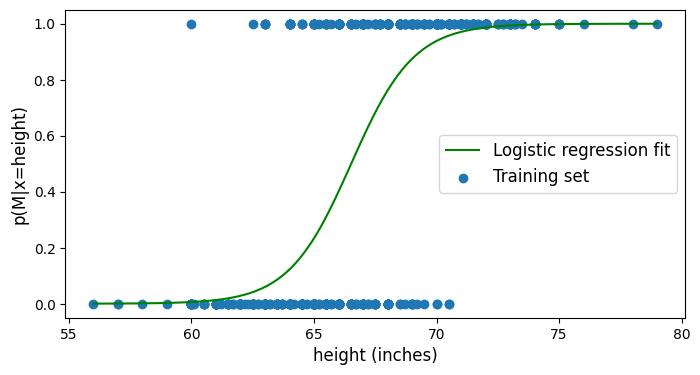

In [13]:
# implement a logistic regression model for binary classification

from sklearn.linear_model import LogisticRegression

# train a linear model for this new data frame
# Use stratified shuffle: the portion of M and F in the train set, test set, and the original data set are consistent

df_reg_train, df_reg_test = train_test_split(df_reg, shuffle=True, stratify=df_reg['M'], random_state=42, test_size=.2)

log_reg=LogisticRegression(penalty=None)
log_reg.fit(df_reg_train[['height']].values, df_reg_train['M'].values)

# Plot figure to see the fitting and the original training set
plt.figure(figsize = (8,4))

plt.plot(np.linspace(min(df_reg_train['height']),max(df_reg_train['height']),500),
            log_reg.predict_proba(np.linspace(min(df_reg_train['height']),max(df_reg_train['height']),500).reshape(-1,1))[:,1],
            'g-',linewidth=1.5,label = "Logistic regression fit")

plt.scatter(df_reg_train['height'],df_reg_train['M'],label = 'Training set')
plt.legend(fontsize = 12)
plt.xlabel("height (inches)",fontsize = 12)
plt.ylabel("p(M|x=height)",fontsize=12) 

plt.show()

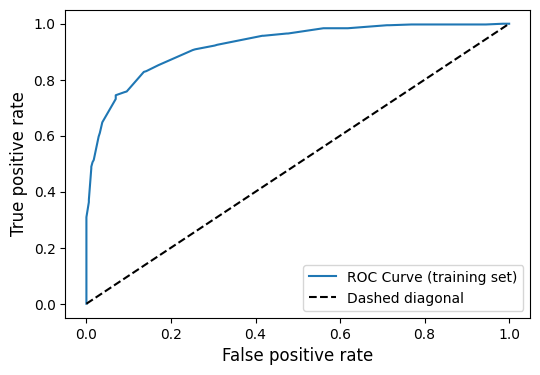

Area under the ROC curve for the training set:  0.92


In [17]:
# Assessing the logistic regression model by the receiver operating characteristic (ROC) curve
# The ROC for a perfect fit is a curve goes from (0,0) to (0,1), then from (0,1) to (1,1)
# If the logistic regression model works well, the area under ROC should be nearly 1

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(df_reg_train['M'], log_reg.predict_proba(df_reg_train[['height']].values)[:,1])

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, label="ROC Curve (training set)")
plt.plot([0,1], [0,1], 'k--', label="Dashed diagonal")

plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

ROC_score = roc_auc_score(df_reg_train['M'], log_reg.predict_proba(df_reg_train[['height']].values)[:,1])
print("Area under the ROC curve for the training set: ", np.round(ROC_score,2))

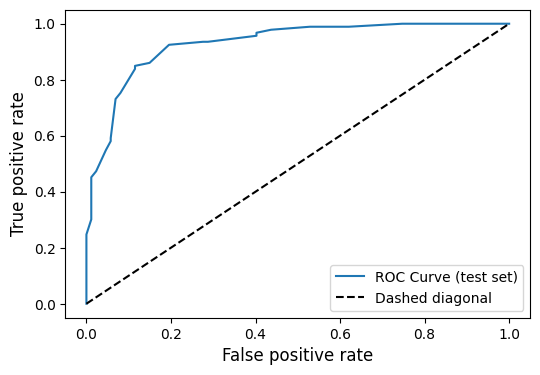

Area under the ROC curve for the training set:  0.93


In [21]:
# Evaluate the ROC and ROC AUC for the test set
# Check if the logistic model can be generalized
# No validation set is used as I do not perform hyperparameter tuning

fpr_test, tpr_test, thresholds_test = roc_curve(df_reg_test['M'], log_reg.predict_proba(df_reg_test[['height']].values)[:,1])

plt.figure(figsize=(6,4))

plt.plot(fpr_test, tpr_test, label="ROC Curve (test set)")
plt.plot([0,1], [0,1], 'k--', label="Dashed diagonal")

plt.xlabel("False positive rate", fontsize=12)
plt.ylabel("True positive rate", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

plt.show()

ROC_score_test = roc_auc_score(df_reg_test['M'], log_reg.predict_proba(df_reg_test[['height']].values)[:,1])
print("Area under the ROC curve for the training set: ", np.round(ROC_score_test,2))

1. Model selection: 
Logistic regression model is used

2. Verification of model assumptions: 
The target is clearly binary (only take 0 or 1). Only one feature is used in the fitting, no issue of multicollinearity.

3. Assessing model fit: 
Area under ROC is about 0.92 (looks fine).

In [22]:
# predict the probability that a person is male if they are 70 inches tall based on your fit model.

X=70
p_F=log_reg.predict_proba([[X]])[:,0]
p_M=log_reg.predict_proba([[X]])[:,1]

print("p(M|X=70) from the logistic regression model:", np.round(*p_M,2), "\n")

# see what happens in the data set for a comparison
nF=((df_reg['height'] >= 70) & (df_reg['M']==0)).sum()
nM=((df_reg['height'] >= 70) & (df_reg['M']==1)).sum()
n=((df_reg['height'] >= 70).sum())

print("# girls taller than 70 inches in the data set:", nF )
print("# boys taller than 70 inches in the data set:", nM )
print("# kids taller than 70 inches in the data set:", n)

print("p(M|X>=70) in the data set: ", np.round(nM/n,2))

p(M|X=70) from the logistic regression model: 0.94 

# girls taller than 70 inches in the data set: 5
# boys taller than 70 inches in the data set: 218
# kids taller than 70 inches in the data set: 223
p(M|X>=70) in the data set:  0.98


* How much do you trust this probability and why?  Answer below.

I think the probability 0.94 can be a good reference if the parents of the kid have heights similar to those given in the data set. This is because the area under the ROC curve for the training set is about 0.92 which indicates that the logistic regression model works fine. This is further supported by the ROC curve for the test set, which has an area under curve 0.93. Also, the scatter plot above shows that there are not many data points which correspond to a girl with height above or equal to 70 inches. Hence, the probability seems to be a good reference. 

However, I won't take the result too seriously. It is because the heights of the parents are not given. If the parents or other family members of the kids are super tall, then the child can be much taller even if she is a girl (our common sense teaches us that genetics plays an important role in the height). To conclude, I will say 0.94 can be a good reference, but we should better know the heights of the parents before making the prediction.